# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import ast
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Read the data

In [ ]:
path_to_file = '/content/drive/MyDrive/TFM/Data/df.csv'

In [ ]:
df = pd.read_csv(path_to_file)

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['supply'] = df['supply_60'].apply(lambda x: ast.literal_eval(x))
df['price'] = df['price_60'].apply(lambda x: ast.literal_eval(x))
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['month'] = df['date'].apply(lambda x: x.month)

In [ ]:
df.head()

,date,hour,price,supply,price_45,supply_45,price_60,supply_60,price_90,supply_90,weekday,month
0,2016-01-01,1,"[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[24390.2, 28305.2, 30847.0, 31282.8, 31375.2, ...","[0, 5, 11, 16, 21, 26, 31, 35, 40, 44, 48, 51,...","[24390.2, 29510.0, 31220.0, 31375.2, 31440.2, ...","[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[24390.2, 28305.2, 30847.0, 31282.8, 31375.2, ...","[0, 2, 5, 8, 11, 13, 16, 18, 21, 23, 26, 28, 3...","[24390.2, 26291.8, 29510.0, 30847.0, 31220.0, ...",4,1
1,2016-01-01,2,"[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[24209.4, 28047.4, 30280.2, 30712.4, 30790.0, ...","[0, 5, 11, 16, 21, 26, 31, 35, 40, 44, 48, 51,...","[24209.4, 29103.0, 30648.800000000003, 30790.0...","[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[24209.4, 28047.4, 30280.2, 30712.4, 30790.0, ...","[0, 2, 5, 8, 11, 13, 16, 18, 21, 23, 26, 28, 3...","[24209.4, 25777.0, 29103.0, 30280.2, 30648.800...",4,1
2,2016-01-01,3,"[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[24926.4, 29180.4, 31439.0, 31870.4, 32055.800...","[0, 5, 11, 16, 21, 26, 31, 35, 40, 44, 48, 51,...","[24926.4, 30235.4, 31807.2, 32055.800000000003...","[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[24926.4, 29180.4, 31439.0, 31870.4, 32055.800...","[0, 2, 5, 8, 11, 13, 16, 18, 21, 23, 26, 28, 3...","[24926.4, 26669.600000000002, 30235.4, 31439.0...",4,1
3,2016-01-01,4,"[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[25871.4, 30802.600000000002, 33117.2000000000...","[0, 5, 11, 16, 21, 26, 31, 35, 40, 44, 48, 51,...","[25871.4, 31861.2, 33488.200000000004, 33636.4...","[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[25871.4, 30802.600000000002, 33117.2000000000...","[0, 2, 5, 8, 11, 13, 16, 18, 21, 23, 26, 28, 3...","[25871.4, 28008.800000000003, 31861.2, 33117.2...",4,1
4,2016-01-01,5,"[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[25973.0, 31594.8, 34023.2, 34463.2, 34576.0, ...","[0, 5, 11, 16, 21, 26, 31, 35, 40, 44, 48, 51,...","[25973.0, 32664.6, 34398.0, 34576.0, 34795.8, ...","[0, 4, 8, 12, 16, 20, 23, 27, 31, 34, 37, 41, ...","[25973.0, 31594.8, 34023.2, 34463.2, 34576.0, ...","[0, 2, 5, 8, 11, 13, 16, 18, 21, 23, 26, 28, 3...","[25973.0, 28319.8, 32664.6, 34023.2, 34398.0, ...",4,1


# Train, validation and test sets for a fixed hour

In [ ]:
HOUR = 0

In [ ]:
dates = list(df['date'].values)
supplies = list(df['supply'].values)
weekdays = list(df['weekday'].values)
months = list(df['month'].values)

In [ ]:
n = len(dates)
HOURS_BEFORE = 24

In [ ]:
X = []
Y_prev = []
Y = []
vectores = [] # para guardar las variables exogenas y concatenarlas despues de normalizar

for i in range(0, n - HOURS_BEFORE, HOURS_BEFORE):

    target = i + HOURS_BEFORE + HOUR

    # Datos de las HOURS_BEFORE horas anteriores
    vec_supplies = []
    for s in supplies[i:i+HOURS_BEFORE]:
        vec_supplies += s

    # Dia de la semana
    vec_weekday = [0 for _ in range(3)]
    if weekdays[target] == 5: # sabado
        vec_weekday[1] = 1
    elif weekdays[target] == 6: # domingo
        vec_weekday[2] = 1
    else: # entre semana
        vec_weekday[0] = 1

    # Estacion
    month = months[target]
    vec_season = [0 for _ in range(4)]
    if 2 <= month <= 4:
        season = 0
    elif 5 <= month <= 7:
        season = 1
    elif 8 <= month <= 10:
        season = 2
    else:
        season = 3
    vec_season[season] = 1

    # Juntamos todo
    vectores.append(vec_weekday + vec_season)

    # X e Y
    X.append(vec_supplies)
    Y_prev.append(supplies[target-24])
    Y.append(supplies[target])

In [ ]:
VALIDATION = False

In [ ]:
N = 60 # numero de puntos en la malla

In [ ]:
if VALIDATION:
    frac_train = 0.6
    frac_valid = 0.2
else:
    frac_train = 0.8

n_train = int(frac_train*len(X))
if VALIDATION:
    n_valid = int(frac_valid*len(X))

In [ ]:
X_train = X[:n_train]
Y_train = Y[:n_train]

if VALIDATION:
    X_valid = X[n_train:n_train+n_valid]
    Y_valid = Y[n_train:n_train+n_valid]
    X_test = X[n_train+n_valid:]
    Y_test = Y[n_train+n_valid:]
    Y_prev = Y_prev[n_train+n_valid:]
else:
    X_test = X[n_train:]
    Y_test = Y[n_train:]
    Y_prev = Y_prev[n_train:]

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
if VALIDATION:
    X_valid = np.array(X_valid)
    Y_valid = np.array(Y_valid)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_prev = np.array(Y_prev)

In [ ]:
min_x = np.min(X_train)
max_x = np.max(X_train)

X_train = (X_train - min_x) / (max_x - min_x)
Y_train = (Y_train - min_x) / (max_x - min_x)
if VALIDATION:
    X_valid = (X_valid - min_x) / (max_x - min_x)
    Y_valid = (Y_valid - min_x) / (max_x - min_x)
X_test = (X_test - min_x) / (max_x - min_x)
Y_test = (Y_test - min_x) / (max_x - min_x)

In [ ]:
X_tr = []
X_va = []
X_te = []

for i, v in enumerate(vectores):
    if i < len(X_train):
        X_tr.append(list(X_train[i]) + v)
    else:
        if VALIDATION:
            if i < len(X_train) + len(X_valid):
                X_va.append(list(X_valid[i-len(X_train)]) + v)
            else:
                X_te.append(list(X_test[i-len(X_train)-len(X_valid)]) + v)
        else:
            X_te.append(list(X_test[i-len(X_train)]) + v)

X_train = np.array(X_tr)
if VALIDATION:
    X_valid = np.array(X_va)
X_test = np.array(X_te)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
if VALIDATION:
    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    Y_valid = torch.tensor(Y_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# LSTM

In [ ]:
class EarlyStopping:


    def __init__(self, patience, path):

        self.patience = patience # epocas permitidas sin mejorar (cuando llegamos a este limite el entrenamiento para)
        self.counter = 0 # para contar las epocas que llevamos sin mejorar
        self.best_score = np.Inf # mejor valor conseguido
        self.early_stop = False # para saber cuando parar
        self.path = path # direccion para guardar los parametros del modelo


    def __call__(self, val_loss, model):

        score = val_loss

        if score >= self.best_score: # no mejoramos
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else: # mejoramos
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0


    def save_checkpoint(self, val_loss, model): # guardamos el modelo y actualizamos el valor minimo de validacion

        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p):

        super().__init__()
        self.exog = input_size > N*HOURS_BEFORE
        self.lstm = nn.LSTM(N*HOURS_BEFORE, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size + (input_size - N*HOURS_BEFORE), hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.fc5 = nn.Linear(hidden_4, n_labels)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p)
                                                                
        
    def forward(self, x):
        
        if self.exog: # las primeras N*DAYS_BEFORE entradas seran los datos de los dias anteriores
            lstm_input = x[:, :N*HOURS_BEFORE]
            exog = x[:, N*HOURS_BEFORE:]
        else:
            lstm_input = x[:, :N*HOURS_BEFORE]

        x, (h, c) = self.lstm(lstm_input)

        """hidden = h.clone()

        for _ in range(x.shape[0]-1):
            hidden = torch.cat((hidden, h), dim=0)
        
        x = torch.cat((x, hidden), dim=1)"""

        if self.exog:
            x = torch.cat((x, exog), dim=1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.sigmoid(x)

        return x

In [ ]:
class LSTM_extended(LSTM):


    def __init__(self, input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p,
                 patience, epochs=50, valid=False, batch_size=128, lr=0.001, print_every=5, path='LSTM_' + str(HOUR) + '.pt'):

        super().__init__(input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.MSELoss()

        self.train_loss = []
        self.valid_loss = []
        self.train_rmse = []
        self.train_mae = []
        self.train_mape = []
        self.train_r2 = []
        self.valid_rmse = []
        self.valid_mae = []
        self.valid_mape = []
        self.valid_r2 = []

        self.valid = valid
        self.batch_size = batch_size
        self.print_every = print_every
        self.path = path
        self.early_stopping = EarlyStopping(patience, self.path)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)                                                
    

    def trainloop(self, x_train, y_train, x_valid, y_valid):

        self.num_train = len(x_train)
        self.num_batchs_train = self.num_train // self.batch_size
        if self.valid:
            self.num_valid = len(x_valid)
            self.num_batchs_valid = self.num_valid // self.batch_size
        
        for e in range(1, self.epochs+1):
            
            # Entrenamiento
            self.train()
            running_loss = 0
            idx_train = np.random.permutation(self.num_train)
            for i in range(self.num_batchs_train):
                idx_batch = idx_train[i*self.batch_size:(i+1)*self.batch_size]
                embeddings, labels = x_train[idx_batch], y_train[idx_batch]
                embeddings, labels = embeddings.to(self.device), labels.to(self.device)
                self.optim.zero_grad()
                out = self.forward(embeddings)
                loss = self.criterion(out, labels)
                loss.backward()
                self.optim.step()
                running_loss += loss.item()
            self.train_loss.append(running_loss/self.num_batchs_train)
            y_pred = self.predict(x_train)
            MSE = mean_squared_error(y_train * (max_x - min_x) + min_x, y_pred)
            RMSE = np.sqrt(MSE)
            MAE = mean_absolute_error(y_train * (max_x - min_x) + min_x, y_pred)
            MAPE = mean_absolute_percentage_error(y_train * (max_x - min_x) + min_x, y_pred)
            R2 = r2_score(y_train * (max_x - min_x) + min_x, y_pred)
            self.train_rmse.append(RMSE)
            self.train_mae.append(MAE)
            self.train_mape.append(100*MAPE)
            self.train_r2.append(R2)

            # Validacion
            if self.valid:
                self.eval()
                running_loss = 0
                idx_valid = np.random.permutation(self.num_valid)
                with torch.no_grad():
                    for i in range(self.num_batchs_valid):
                        idx_batch = idx_valid[i*self.batch_size:(i+1)*self.batch_size]
                        embeddings, labels = x_valid[idx_batch], y_valid[idx_batch]
                        embeddings, labels = embeddings.to(self.device), labels.to(self.device)
                        out = self.forward(embeddings)
                        loss = self.criterion(out, labels)
                        running_loss += loss.item()
                self.valid_loss.append(running_loss/self.num_batchs_valid)
                y_pred = self.predict(x_valid)
                MSE = mean_squared_error(y_valid * (max_x - min_x) + min_x, y_pred)
                RMSE = np.sqrt(MSE)
                MAE = mean_absolute_error(y_valid * (max_x - min_x) + min_x, y_pred)
                MAPE = mean_absolute_percentage_error(y_valid * (max_x - min_x) + min_x, y_pred)
                R2 = r2_score(y_valid * (max_x - min_x) + min_x, y_pred)
                self.valid_rmse.append(RMSE)
                self.valid_mae.append(MAE)
                self.valid_mape.append(100*MAPE)
                self.valid_r2.append(R2)

            # Verbose
            if e % self.print_every == 0 or e == 1:
                print('\nEpoch {}\n'.format(e))
                print('Training loss: {}'.format(self.train_loss[-1]))
                if self.valid:
                    print('Validation loss: {}'.format(self.valid_loss[-1]))
            
            # Early stopping
            if self.valid:
                self.early_stopping(self.valid_loss[-1], self)
                if self.early_stopping.early_stop:
                    print('Early stopping')
                    self.load_state_dict(torch.load(self.path))
                    break


    def predict(self, x_batch):

        self.eval()
        
        with torch.no_grad():
            preds = np.array(self.forward(x_batch).detach().numpy()) * (max_x - min_x) + min_x
        
        return preds


    def show_training(self):

        plt.figure(figsize=(14, 8))
        plt.grid()
        plt.xlabel('Epoch')
        plt.plot(range(1, len(self.train_loss)+1), self.train_loss)
        if self.valid:
            plt.plot(range(1, len(self.valid_loss)+1), self.valid_loss)
            plt.legend(['Train', 'Validation'])

        plt.figure(figsize=(14, 8))
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.plot(range(1, len(self.train_rmse)+1), self.train_rmse)
        if self.valid:
            plt.plot(range(1, len(self.valid_rmse)+1), self.valid_rmse)
            plt.legend(['Train', 'Validation'])
        
        plt.figure(figsize=(14, 8))
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.plot(range(1, len(self.train_mae)+1), self.train_mae)
        if self.valid:
            plt.plot(range(1, len(self.valid_mae)+1), self.valid_mae)
            plt.legend(['Train', 'Validation'])

        plt.figure(figsize=(14, 8))
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('MAPE')
        plt.plot(range(1, len(self.train_mape)+1), self.train_mape)
        if self.valid:
            plt.plot(range(1, len(self.valid_mape)+1), self.valid_mape)
            plt.legend(['Train', 'Validation'])
        
        plt.figure(figsize=(14, 8))
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('$R^2$')
        plt.plot(range(1, len(self.train_r2)+1), self.train_r2)
        if self.valid:
            plt.plot(range(1, len(self.valid_r2)+1), self.valid_r2)
            plt.legend(['Train', 'Validation'])

# Entrenamiento

In [ ]:
SEED = 9

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
input_size = N*HOURS_BEFORE + 3 + 4
hidden_size = 2048
hidden_1 = 1024
hidden_2 = 1024
hidden_3 = 512
hidden_4 = 256
n_labels = N
p = 0.2
patience = 15
epochs = 500
valid = True

my_LSTM = LSTM_extended(input_size, hidden_size, hidden_1, hidden_2, hidden_3, hidden_4, n_labels, p, patience, valid=valid, epochs=epochs)

In [ ]:
if VALIDATION:
    my_LSTM.trainloop(X_train, Y_train, X_valid, Y_valid)
else:
    my_LSTM.trainloop(X_train, Y_train, X_test, Y_test)


Epoch 1

Training loss: 0.018786007227996986
Validation loss: 0.005475392332300544

Epoch 5

Training loss: 0.005941376348750459
Validation loss: 0.003662489354610443

Epoch 10

Training loss: 0.005336023453209136
Validation loss: 0.003844793885946274

Epoch 15

Training loss: 0.004755848527161611
Validation loss: 0.003116804640740156

Epoch 20

Training loss: 0.004338969683481587
Validation loss: 0.002605808898806572

Epoch 25

Training loss: 0.0036941605827046763
Validation loss: 0.002111156762111932

Epoch 30

Training loss: 0.0028481276240199804
Validation loss: 0.0019129349966533482

Epoch 35

Training loss: 0.00308824030475484
Validation loss: 0.0021107809152454138

Epoch 40

Training loss: 0.0027851032403608165
Validation loss: 0.0017607522895559669

Epoch 45

Training loss: 0.002394826151430607
Validation loss: 0.0018030343926511705

Epoch 50

Training loss: 0.0025247056813289723
Validation loss: 0.002075124066323042

Epoch 55

Training loss: 0.002381369937211275
Validation lo

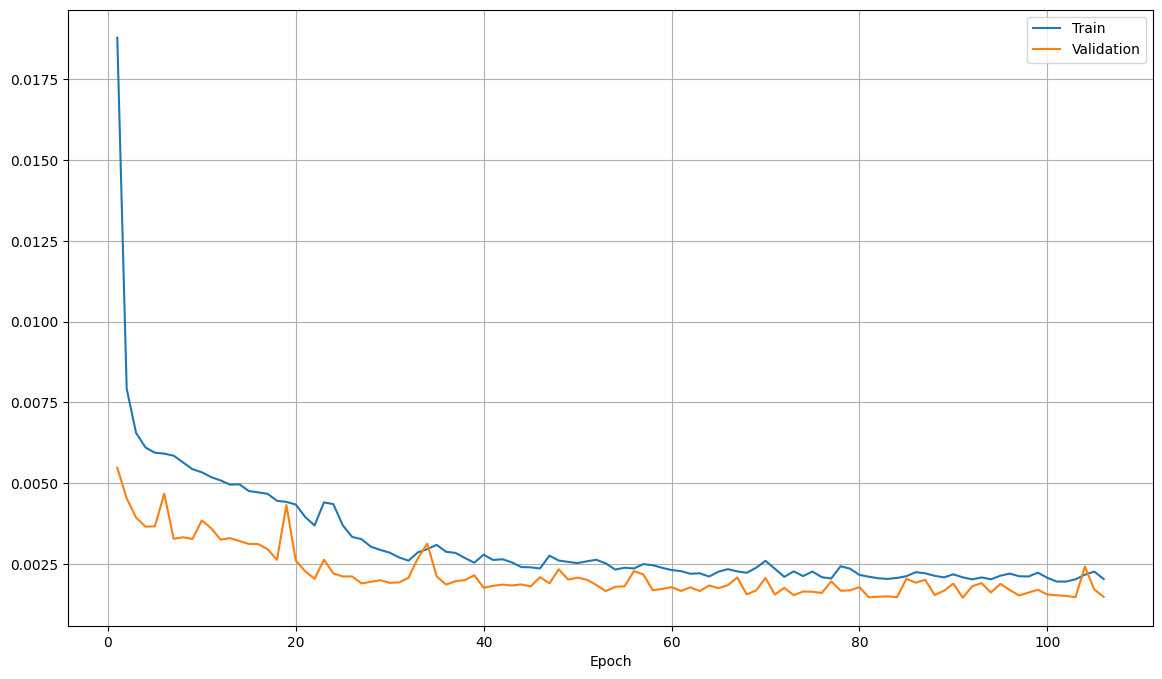

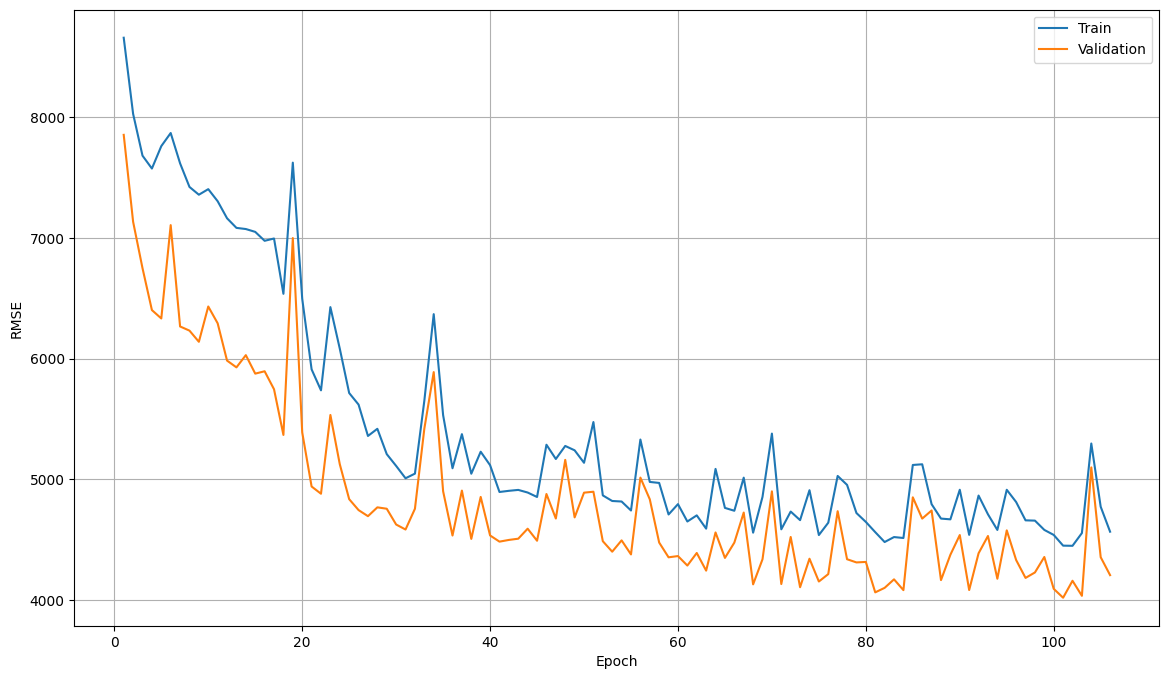

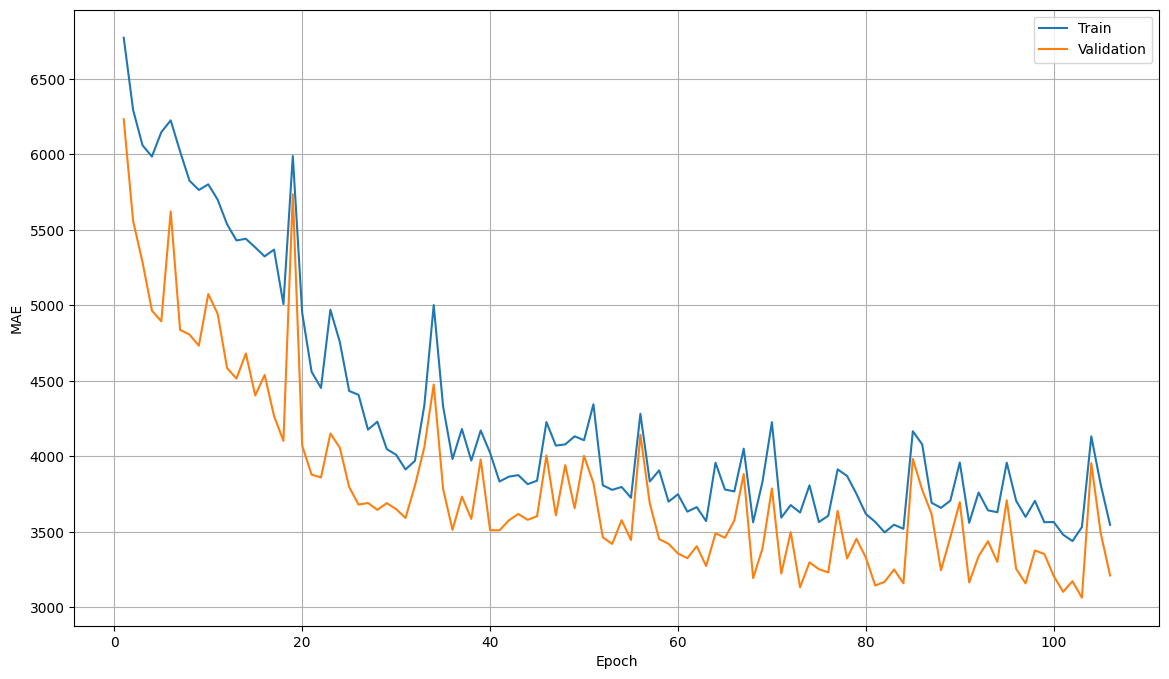

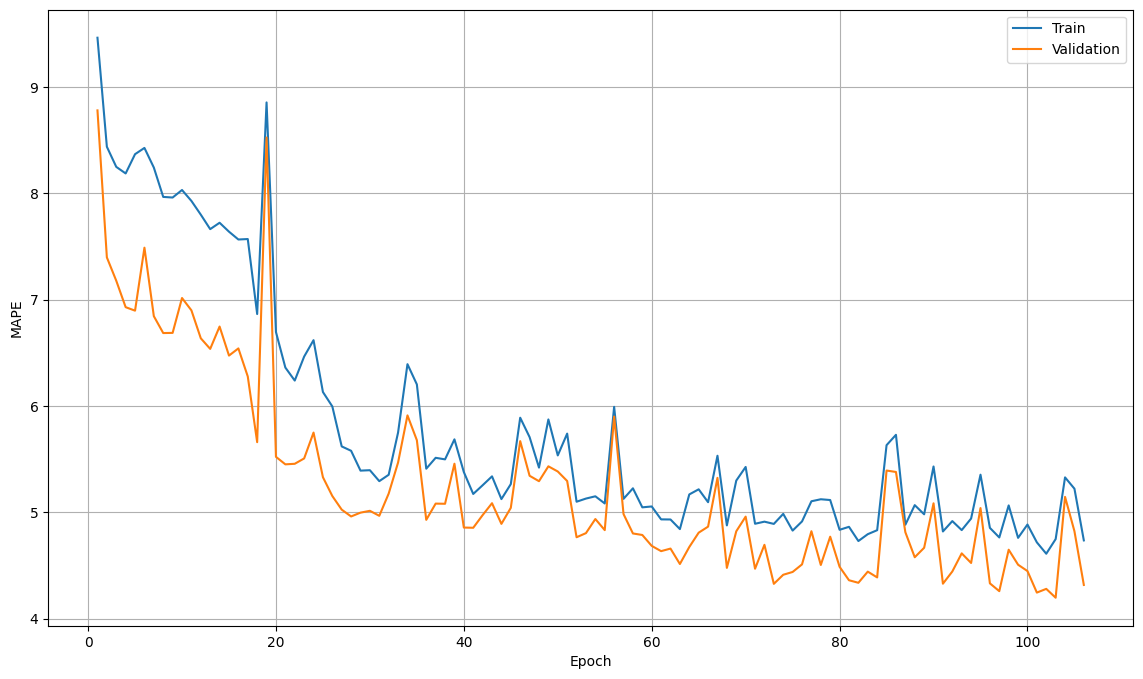

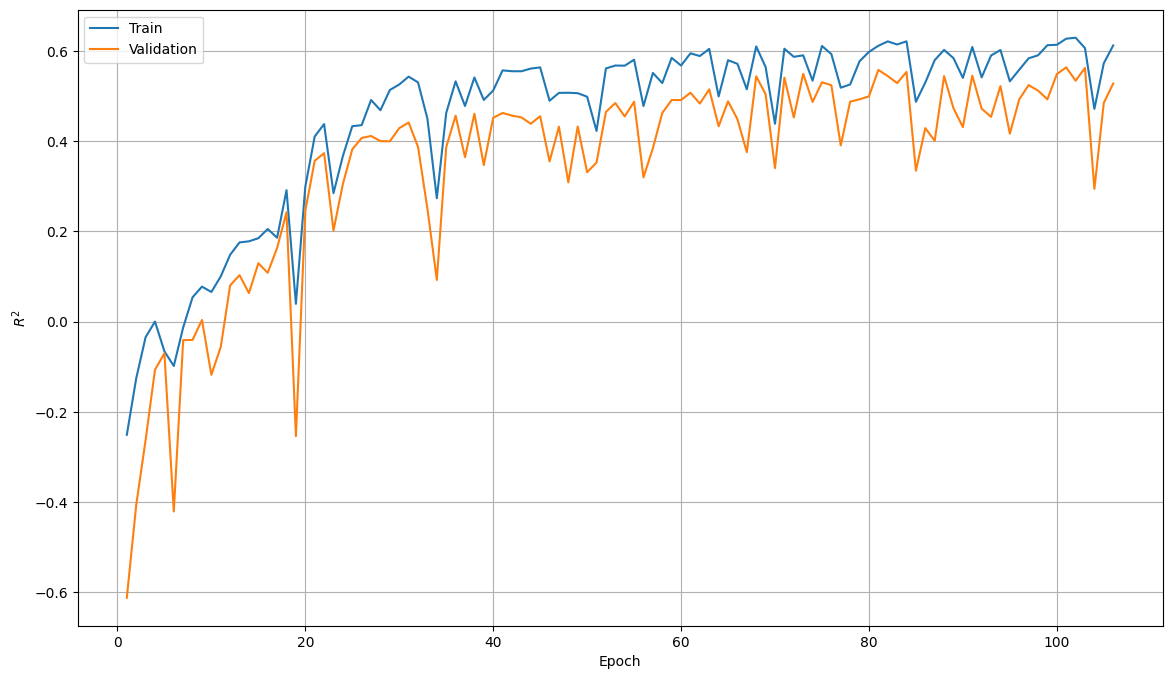

In [ ]:
my_LSTM.show_training()

# Test

In [ ]:
Y_test_2 = Y_test * (max_x - min_x) + min_x

In [ ]:
Y_pred = my_LSTM.predict(X_test)

In [ ]:
MSE = mean_squared_error(Y_test_2, Y_pred)
RMSE = np.sqrt(MSE)
print('RMSE:', RMSE)
MAE = mean_absolute_error(Y_test_2, Y_pred)
print('MAE:', MAE)
MAPE = mean_absolute_percentage_error(Y_test_2, Y_pred)
print('MAPE:', 100*MAPE)
R2 = r2_score(Y_test_2, Y_pred)
print('R2:', R2)

RMSE: 4082.9983
MAE: 3164.5103
MAPE: 4.328883811831474
R2: 0.5450478231489903


In [ ]:
print('Heuristica\n')
MSE = mean_squared_error(Y_test_2, Y_prev)
RMSE = np.sqrt(MSE)
print('RMSE:', RMSE)
MAE = mean_absolute_error(Y_test_2, Y_prev)
print('MAE:', MAE)
MAPE = mean_absolute_percentage_error(Y_test_2, Y_prev)
print('MAPE:', 100*MAPE)
R2 = r2_score(Y_test_2, Y_prev)
print('R2:', R2)

Heuristica

RMSE: 5222.670651539655
MAE: 4027.7781403396125
MAPE: 5.358711584409776
R2: 0.23648109863189692


In [ ]:
def view_pred():

    # Comparacion de un dia aleatorio

    idx = np.random.randint(0, len(Y_test))

    plt.figure(figsize=(10, 6))

    plt.grid()
    plt.step(df['price'].iloc[0], Y_test_2[idx], color='#051C2C', where='post')
    plt.step(df['price'].iloc[0], Y_pred[idx], color='#0EA9F0', where='post')
    # plt.step(df['price'].iloc[0], Y_prev[idx], color='g', where='post')
    plt.legend(['Real', 'LSTM', 'Día anterior'])
    plt.xlabel('Precio (€)')
    plt.ylabel('Cantidad (kWh)')
    plt.title('Un día aleatorio')

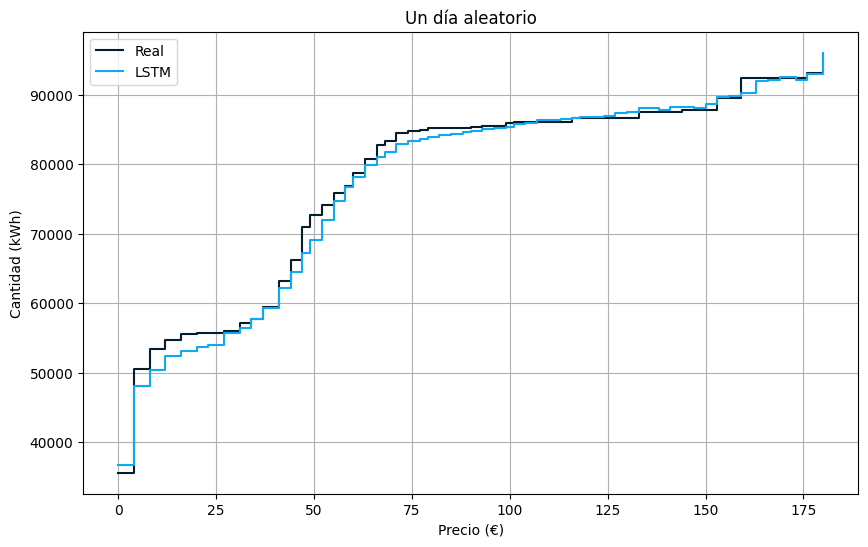

In [ ]:
view_pred()